In [1]:
# Library
import os
import pandas as pd
import numpy as np

# Plot
import matplotlib
import matplotlib.pyplot as plt

# Machine Learning Functions
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score,roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
import keras_tuner as kt
from keras_tuner import Objective
from keras import layers
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

C:\Users\Marc\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [17]:
# Functions
# Class names
class_names = ['No EA', 'EA']

# Seed
myseed = 32

def show_distribution(y, title="Distribución"):
    """
    Función para mostrar la distribucion de las clases
    Arg:
    y: variable clase
    Title: Título del plot
    """
    freq = y.value_counts()
    plt.pie(freq, labels=('No EA ('+str(freq[0])+')', 'EA ('+str(freq[1])+')'), 
            autopct='%1.1f%%', colors=["lightblue", "darkblue"])
    plt.title(title)

def plot_confusion_matrix(y_test, y_pred, model_name="model", file_name="name"):
    """
    Función para mostrar la matriz de confusión y guarda el plot en el directorio de trabajo
    Arg:
    y_test : Variable clase original
    y_pred: Variable clase predictora
    model_name: nombre del modelo
    file_name: nombre del archivo a guardar
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title('Matriz de confusión - {}'.format(model_name))
    plt.tight_layout()
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc(y_test, y_prob, model_name="model", file_name="name"):
    """
    Función para mostrar la curva ROC y guardar el plot en el directorio de trabajo
    Arg:
    y_test: Variable clase original
    y_prob: probabilidad variable predictora
    model: nombre del modelo
    file_name: nomrbre del archivo a guardar
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label= "{}, auc={:.4f}".format(model_name, auc), color="darkblue")
    plt.plot([0,1], [0,1], 'k--')
    plt.title("Curva Roc - {}".format(model_name))
    plt.xlabel("Tasa Falsos Positivos(1- Especificidad)")
    plt.ylabel("Tasa Verdaderos Positivos (Sensibilidad)")
    plt.legend(loc="lower right")
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

In [2]:
# Set directory
os.chdir('C:/Users/Marc/OneDrive/Escritorio/Marc/TFM')
os.getcwd()

'C:\\Users\\Marc\\OneDrive\\Escritorio\\Marc\\TFM'

In [19]:
# Load data variable significants
data = pd.read_csv('data_sig.csv')
data.info()
data.head(5)

# Load data full variables
data_2 = pd.read_csv('data_full.csv')
data_2.info()
data_2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diag                  2149 non-null   int64  
 1   MMSE                  2149 non-null   float64
 2   MemoryComplaints      2149 non-null   object 
 3   BehavioralProblems    2149 non-null   object 
 4   CholesterolLDL        2149 non-null   float64
 5   CholesterolHDL        2149 non-null   float64
 6   FunctionalAssessment  2149 non-null   float64
 7   SleepQuality          2149 non-null   float64
 8   ADL                   2149 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 151.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   in

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diag
0,73,Male,Caucasica,Universitaria,22.927749,No,13.297218,6.327112,1.347214,9.025679,...,6.518877,No,No,1.725883,No,No,No,Si,No,0
1,89,Male,Caucasica,Ninguna,26.827681,No,4.542524,7.619885,0.518767,7.151293,...,7.118696,No,No,2.592424,No,No,No,No,Si,0
2,73,Male,Otra,Secundaria,17.795882,No,19.555085,7.844988,1.826335,9.673574,...,5.895077,No,No,7.119548,No,Si,No,Si,No,0
3,74,Female,Caucasica,Secundaria,33.800817,Si,12.209266,8.428001,7.435604,8.392554,...,8.965106,No,Si,6.481226,No,No,No,No,No,0
4,89,Male,Caucasica,Ninguna,20.716974,No,18.454356,6.310461,0.795498,5.597238,...,6.045039,No,No,0.014691,No,No,Si,Si,No,0


In [20]:
# Change categorical variables significants
categorical = ['MemoryComplaints', 'BehavioralProblems']
for var in categorical:
    data[var] = data[var].map({'No': 0, 'Si': 1})

data.info()
data.head(5)

# Change categorical bynary variables in full data
categorical_b = data_2.select_dtypes(include=['object']).columns.drop(['Gender', 'Ethnicity', 'EducationLevel'])

for var in categorical_b:
    data_2[var] = data_2[var].map({'No': 0, 'Si': 1})

data_2['Gender'] = data_2['Gender'].map({'Male': 0, 'Female': 1})

data_2.info()
data_2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diag                  2149 non-null   int64  
 1   MMSE                  2149 non-null   float64
 2   MemoryComplaints      2149 non-null   int64  
 3   BehavioralProblems    2149 non-null   int64  
 4   CholesterolLDL        2149 non-null   float64
 5   CholesterolHDL        2149 non-null   float64
 6   FunctionalAssessment  2149 non-null   float64
 7   SleepQuality          2149 non-null   float64
 8   ADL                   2149 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 151.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   G

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diag
0,73,0,Caucasica,Universitaria,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,Caucasica,Ninguna,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,Otra,Secundaria,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,Caucasica,Secundaria,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,Caucasica,Ninguna,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [21]:
# Split y, X
# Var. significants
y = data["Diag"]
X = data.drop(columns=["Diag"])

print('Los descriptores con variables signifitcativas son: \n{}'.format(X))
print('La variable respues es: \n{}'.format(y))

# Full variables
y_2 = data_2["Diag"]
X_2 = data_2.drop(columns=["Diag"])

print('Los desciptores con todas las variables son: \n{}'.format(X_2))
print('La variable respuesta es: \n{}'.format(y_2))

Los descriptores con variables signifitcativas son: 
           MMSE  MemoryComplaints  BehavioralProblems  CholesterolLDL  \
0     21.463532                 0                   0       56.150897   
1     20.613267                 0                   0      193.407996   
2      7.356249                 0                   0      153.322762   
3     13.991127                 0                   1       65.366637   
4     13.517609                 0                   0       92.869700   
...         ...               ...                 ...             ...   
2144   1.201190                 0                   0       94.870490   
2145   6.458060                 0                   1       95.410700   
2146  17.011003                 0                   0      156.267294   
2147   4.030491                 0                   0       52.482961   
2148  11.114777                 0                   1       92.200064   

      CholesterolHDL  FunctionalAssessment  SleepQuality       ADL  
0

In [22]:
# Split train-test
# Var. significants
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=myseed)
print("Dimensions X:", X.shape)
print("Dimensions X_train:", X_train.shape)
print("Dimensions X_test:", X_test.shape)

# Full variable
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2,
                                                    random_state=myseed)
print("Dimensions X:", X_2.shape)
print("Dimensions X_2_train:", X_2_train.shape)
print("Dimensions X_2_test:", X_2_test.shape)

Dimensions X: (2149, 8)
Dimensions X_train: (1719, 8)
Dimensions X_test: (430, 8)
Dimensions X: (2149, 32)
Dimensions X_2_train: (1719, 32)
Dimensions X_2_test: (430, 32)


In [23]:
# One_hot_encoding categorical variables full variables
one_hot = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Ethnicity',	'EducationLevel']))

# Train
X_one_hot = one_hot.fit_transform(X_2_train)

one_hot_df = pd.DataFrame(X_one_hot, columns=one_hot.get_feature_names_out())
one_hot_df.index = X_2_train.index

X_2_train = pd.concat([X_2_train, one_hot_df], axis=1)

X_2_train.drop(['Ethnicity',	'EducationLevel'], axis=1, inplace=True)

X_2_train.head()

# Test
X_one_hot_2 = one_hot.fit_transform(X_2_test)

one_hot_df_2 = pd.DataFrame(X_one_hot_2, columns=one_hot.get_feature_names_out())
one_hot_df_2.index = X_2_test.index

X_2_test = pd.concat([X_2_test, one_hot_df_2], axis=1)

X_2_test.drop(['Ethnicity',	'EducationLevel'], axis=1, inplace=True)

X_2_test.head()

,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,DifficultyCompletingTasks,Forgetfulness,onehotencoder__Ethnicity_Afroamericana,onehotencoder__Ethnicity_Asiatica,onehotencoder__Ethnicity_Caucasica,onehotencoder__Ethnicity_Otra,onehotencoder__EducationLevel_Ninguna,onehotencoder__EducationLevel_Secundaria,onehotencoder__EducationLevel_Superior,onehotencoder__EducationLevel_Universitaria
2107,88,0,39.774173,0,11.136302,4.127906,4.568147,7.903963,0,0,...,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1721,77,1,28.536407,1,19.596522,0.406111,2.929292,6.644174,1,0,...,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
91,71,0,19.038815,0,19.483501,8.072807,0.974542,9.078879,0,0,...,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2032,88,1,26.489990,0,18.968614,5.422803,9.503776,9.907700,0,0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
474,89,0,37.639825,0,19.903820,6.284359,0.757733,5.149191,1,1,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


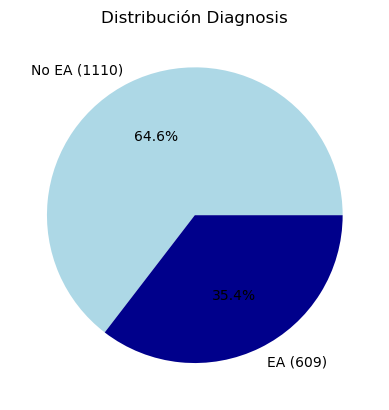

In [24]:
# Distribution variable class
show_distribution(y_train, "Distribución Diagnosis")
plt.savefig("dist_diag.png", dpi=300, bbox_inches='tight')

C:\Users\Marc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Marc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


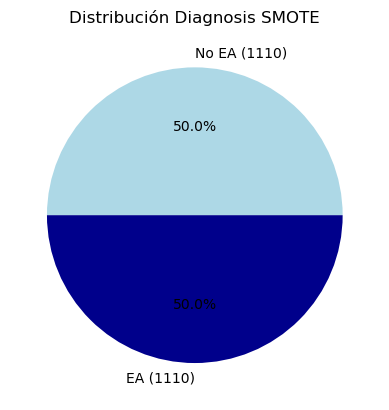

In [25]:
# Data balancing
# Significant variables
smote = SMOTE(random_state=myseed)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Full variables
X_2_smote, y_2_smote = smote.fit_resample(X_2_train, y_2_train)
    
show_distribution(y_smote, "Distribución Diagnosis SMOTE")
plt.savefig("dist_diag_SMOTE.png", dpi=300, bbox_inches='tight')

In [26]:
# Standarize data
scaler = StandardScaler()
min = MinMaxScaler(feature_range=(0, 1))

# Significant variables Standard Scaler transform
X_smote_ss = scaler.fit_transform(X_smote)
X_test_ss = scaler.transform(X_test)

# Significant variables MinMax transform
X_smote_mm = min.fit_transform(X_smote)
X_test_mm = min.transform(X_test)

# Full variables Standard Scaler transform
X_2_smote_ss = scaler.fit_transform(X_2_smote)
X_2_test_ss = scaler.transform(X_2_test)

# Full variablesMinMax transform
X_2_smote_mm = min.fit_transform(X_2_smote)
X_2_test_mm = min.transform(X_2_test)

In [15]:
# GridSearch Knn
knn = KNeighborsClassifier()
param_grid_knn = {"n_neighbors": range(1, 50)}

# Significant variables StandardScaler
grid_search_knn_ss = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)
grid_search_knn_ss.fit(X_smote_ss, y_smote)

# Significant variables MinMax
grid_search_knn_mm = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)
grid_search_knn_mm.fit(X_smote_mm, y_smote)

# Full variables StandardScaler
grid_search_knn_2_ss = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)
grid_search_knn_2_ss.fit(X_2_smote_ss, y_2_smote)

# Full variables MinMax
grid_search_knn_2_mm = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)
grid_search_knn_2_mm.fit(X_2_smote_mm, y_2_smote)

# Print resuults
print('Mejor GridSearchCV knn StandardScaler variables signicativas: {:.2f}\n\n'.format(grid_search_knn_ss.best_score_))
print('Parametros mejor GridSearch knn StandadardScaler variables significativas:','\n\n', (grid_search_knn_ss.best_params_))

print('Mejor GridSearchCV knn MinMAX variables significativas: {:.2f}\n\n'.format(grid_search_knn_mm.best_score_))
print('Parametros mejor GridSearch knn MinMax variables significativas:','\n\n', (grid_search_knn_mm.best_params_))


print('Mejor GridSearchCV knn StandardScaler todas variables: {:.2f}\n\n'.format(grid_search_knn_2_ss.best_score_))
print('Parametros mejor GridSearch knn StandadardScaler todas variables:','\n\n', (grid_search_knn_2_ss.best_params_))

print('Mejor GridSearchCV knn MinMax todas variables: {:.2f}\n\n'.format(grid_search_knn_2_mm.best_score_))
print('Parametros mejor GridSearch knn MinMax todas variables:','\n\n', (grid_search_knn_2_mm.best_params_))

# Build models
knn_ss = grid_search_knn_ss.best_estimator_
knn_mm = grid_search_knn_mm.best_estimator_
knn_2_ss = grid_search_knn_2_ss.best_estimator_
knn_2_mm = grid_search_knn_2_mm.best_estimator_

Mejor GridSearchCV knn StandardScaler variables signicativas: 0.84


Parametros mejor GridSearch knn StandadardScaler variables significativas: 

 {'n_neighbors': 10}
Mejor GridSearchCV knn MinMAX variables significativas: 0.84


Parametros mejor GridSearch knn MinMax variables significativas: 

 {'n_neighbors': 8}
Mejor GridSearchCV knn StandardScaler todas variables: 0.76


Parametros mejor GridSearch knn StandadardScaler todas variables: 

 {'n_neighbors': 2}
Mejor GridSearchCV knn MinMax todas variables: 0.72


Parametros mejor GridSearch knn MinMax todas variables: 

 {'n_neighbors': 4}


In [16]:
# Accuracy train CV
# Significant variables Knn StandardScaler
cvscores_knn_ss = cross_val_score(knn_ss, X_smote_ss, y_smote, cv=5)

# Significant variables Knn MinMax
cvscores_knn_mm = cross_val_score(knn_mm, X_smote_mm, y_smote, cv=5)

# Full variables Knn StandardScaler
cvscores_knn_2_ss = cross_val_score(knn_2_ss, X_2_smote_ss, y_2_smote, cv=5)

# Full variables Knn MinMac 
cvscores_knn_2_mm = cross_val_score(knn_2_mm, X_2_smote_mm, y_2_smote, cv=5)

# Print results
print("Precisión media obtenida variables significtivas StandardScaler knn con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_knn_ss)*100, np.std(cvscores_knn_ss)*100))
print("Precisión media obtenida variables significtivas MinMax knn con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_knn_mm)*100, np.std(cvscores_knn_mm)*100))
print("Precisión media obtenida todas significtivas StandardScaler knn con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_knn_2_ss)*100, np.std(cvscores_knn_2_ss)*100))
print("Precisión media obtenida todas significtivas MinMax knn con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_knn_2_mm)*100, np.std(cvscores_knn_2_mm)*100))

Precisión media obtenida variables significtivas StandardScaler knn con  CV: 83.74 +- 1.83
Precisión media obtenida variables significtivas MinMax knn con  CV: 83.83 +- 2.57
Precisión media obtenida todas significtivas StandardScaler knn con  CV: 75.63 +- 6.45
Precisión media obtenida todas significtivas MinMax knn con  CV: 71.58 +- 7.98


In [17]:
# Knn fit-Test Validate
# Significant variables Standard Scaler
knn_ss.fit(X_smote_ss, y_smote)
y_pred_knn_ss = knn_ss.predict(X_test_ss)

# Significant variables MinMax
knn_mm.fit(X_smote_mm, y_smote)
y_pred_knn_mm = knn_mm.predict(X_test_mm)

# Full variables Standard Scaler
knn_2_ss.fit(X_2_smote_ss, y_2_smote)
y_pred_knn_2_ss = knn_2_ss.predict(X_2_test_ss)

# Full variables MinMax
knn_2_mm.fit(X_2_smote_mm, y_2_smote)
y_pred_knn_2_mm = knn_2_mm.predict(X_2_test_mm)

# Test validate Significant variables StandardScaler
accuracy_knn_ss = accuracy_score(y_test, y_pred_knn_ss)
f1_knn_ss = f1_score(y_test, y_pred_knn_ss)

# Test validate Significant variables MinMax
accuracy_knn_mm = accuracy_score(y_test, y_pred_knn_mm)
f1_knn_mm = f1_score(y_test, y_pred_knn_mm)

# Test validate full variables StandardScaler
accuracy_knn_2_ss = accuracy_score(y_2_test, y_pred_knn_2_ss)
f1_knn_2_ss = f1_score(y_2_test, y_pred_knn_2_ss)

# Test validate full variables MinMax
accuracy_knn_2_mm = accuracy_score(y_2_test, y_pred_knn_2_mm)
f1_knn_2_mm = f1_score(y_2_test, y_pred_knn_2_mm)

# Print results
print("Accuracy Significant variables StandardScaler knn: {:.2f}".format((accuracy_knn_ss)*100))
print("F1-score Significant variables StandardScaler knn: {:.2f}".format((f1_knn_ss)*100))
print("Accuracy Significant variables MinMax knn: {:.2f}".format((accuracy_knn_mm)*100))
print("F1-score Significant variables MinMax knn: {:.2f}".format((f1_knn_mm)*100))
print("Accuracy Full variables StandardScaler knn: {:.2f}".format((accuracy_knn_2_ss)*100))
print("F1-score Full variables StandardScaler knn: {:.2f}".format((f1_knn_2_ss)*100))
print("Accuracy Full variables MinMax knn: {:.2f}".format((accuracy_knn_2_mm)*100))
print("F1-score Full variables MinMax knn: {:.2f}".format((f1_knn_2_mm)*100))

Accuracy Significant variables StandardScaler knn: 84.19
F1-score Significant variables StandardScaler knn: 79.01
Accuracy Significant variables MinMax knn: 85.12
F1-score Significant variables MinMax knn: 80.00
Accuracy Full variables StandardScaler knn: 69.77
F1-score Full variables StandardScaler knn: 55.78
Accuracy Full variables MinMax knn: 66.74
F1-score Full variables MinMax knn: 56.00


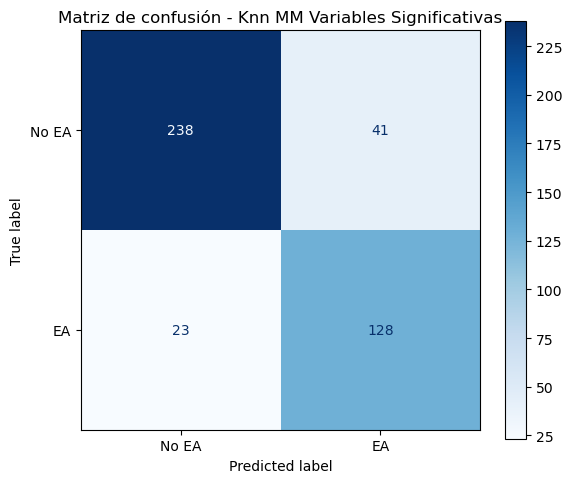

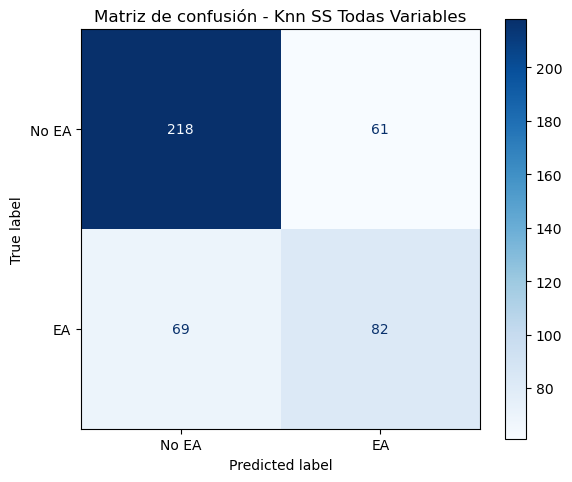

In [18]:
# Matrix confusion
# Significant variables MinMax Knn 
plot_confusion_matrix(y_test, y_pred_knn_mm, "Knn MM Variables Significativas", "cm_knn_mm.png")

# Full variables StandardScaler Knn
plot_confusion_matrix(y_2_test, y_pred_knn_2_ss, "Knn SS Todas Variables", "cm_knn_ss_full.png")

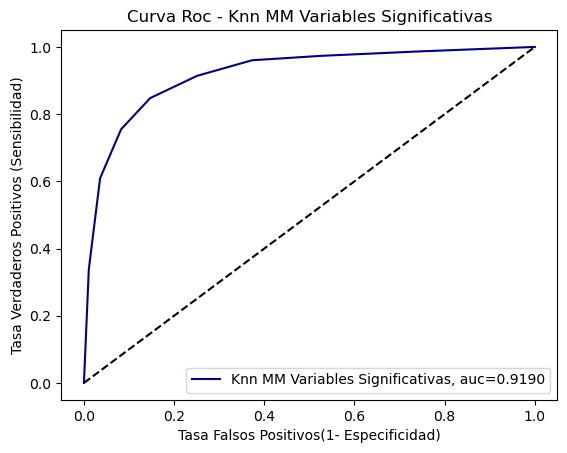

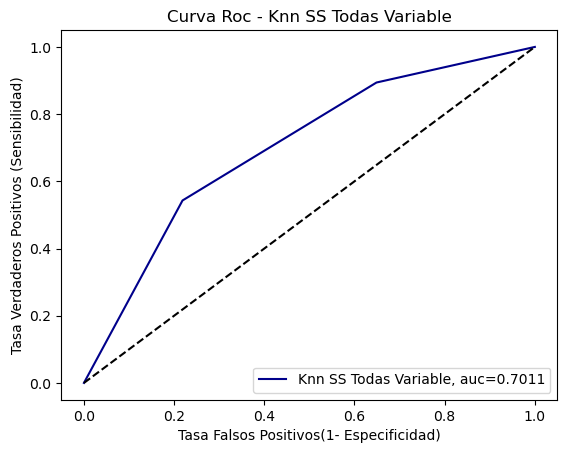

In [19]:
# ROC-AUC
# Significant variables MinMax knn
y_prob_knn_mm = knn_mm.predict_proba(X_test_mm)[:,1]
plot_roc(y_test, y_prob_knn_mm, "Knn MM Variables Significativas", "roc_knn_mm.png")

# Full variables StandardScaker knn
y_prob_knn_2_ss = knn_2_ss.predict_proba(X_2_test_ss)[:,1]
plot_roc(y_2_test, y_prob_knn_2_ss, "Knn SS Todas Variable", "roc_knn_ss_full.png")

In [20]:
# GridSearch Logistic Regression
logreg = LogisticRegression(random_state=myseed)

param_grid = [{"penalty": ['l1'], "C": [0.01, 0.1, 1, 10, 100, 100], "solver": ['liblinear', 'saga']},
              {"penalty": ['l2'], "C": [0.01, 0.1, 1, 10, 100, 100],
                "solver": ['liblinear', 'lbfgs', 'newton-cholesky', 'saga', 'sag']}
             ]
# Significant variables original values
grid_search_logreg = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_smote, y_smote)

# Significant variables StandardScaler
grid_search_logreg_ss = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_logreg_ss.fit(X_smote_ss, y_smote)

# Significant variables MinMax
grid_search_logreg_mm = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_logreg_mm.fit(X_smote_mm, y_smote)

# Full variables original values
grid_search_logreg_2 = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_logreg_2.fit(X_2_smote, y_2_smote)

# Full variables StandardScaler
grid_search_logreg_ss_2 = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_logreg_ss_2.fit(X_2_smote_ss, y_2_smote)

# Full variables MinMax
grid_search_logreg_mm_2 = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_logreg_mm_2.fit(X_2_smote_mm, y_2_smote)

# Print results
print('Mejor GridSearchCV logreg valores originals variables signicativas: {:.2f}\n\n'.format(grid_search_logreg.best_score_))
print('Parametros mejor GridSearch valores originales variables significativas:','\n\n', (grid_search_logreg.best_params_))

print('Mejor GridSearchCV logreg StandardScaler variables signicativas: {:.2f}\n\n'.format(grid_search_logreg_ss.best_score_))
print('Parametros mejor GridSearch logreg StandadardScaler variables significativas:','\n\n', (grid_search_logreg_ss.best_params_))

print('Mejor GridSearchCV logreg MinMAX variables significativas: {:.2f}\n\n'.format(grid_search_logreg_mm.best_score_))
print('Parametros mejor GridSearch logreg MinMax variables significativas:','\n\n', (grid_search_logreg_mm.best_params_))


print('Mejor GridSearchCV logreg valores originals todas variables: {:.2f}\n\n'.format(grid_search_logreg_2.best_score_))
print('Parametros mejor GridSearch valores originales todas variables:','\n\n', (grid_search_logreg_2.best_params_))

print('Mejor GridSearchCV logreg StandardScaler todas variables: {:.2f}\n\n'.format(grid_search_logreg_ss_2.best_score_))
print('Parametros mejor GridSearch logreg StandadardScaler todas variables:','\n\n', (grid_search_logreg_ss_2.best_params_))

print('Mejor GridSearchCV logreg MinMAX todas variables: {:.2f}\n\n'.format(grid_search_logreg_mm_2.best_score_))
print('Parametros mejor GridSearch logreg MinMax todas variables:','\n\n', (grid_search_logreg_mm_2.best_params_))

# Build models
logreg = grid_search_logreg.best_estimator_
logreg_ss = grid_search_logreg_ss.best_estimator_
logreg_mm = grid_search_logreg_mm.best_estimator_
logreg_2 = grid_search_logreg_2.best_estimator_
logreg_ss_2 = grid_search_logreg_ss_2.best_estimator_
logreg_mm_2 = grid_search_logreg_mm_2.best_estimator_

C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was re

Mejor GridSearchCV logreg valores originals variables signicativas: 0.79


Parametros mejor GridSearch valores originales variables significativas: 

 {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor GridSearchCV logreg StandardScaler variables signicativas: 0.79


Parametros mejor GridSearch logreg StandadardScaler variables significativas: 

 {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor GridSearchCV logreg MinMAX variables significativas: 0.79


Parametros mejor GridSearch logreg MinMax variables significativas: 

 {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor GridSearchCV logreg valores originals todas variables: 0.80


Parametros mejor GridSearch valores originales todas variables: 

 {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Mejor GridSearchCV logreg StandardScaler todas variables: 0.80


Parametros mejor GridSearch logreg StandadardScaler todas variables: 

 {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor GridSearchCV logreg MinMA

C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
# Accuracy train CV
# Significant variables original values logistic regression
cvscores_lr = cross_val_score(logreg, X_smote, y_smote, cv=5)

# Significant variables StandardScaler logistic regresion
cvscores_lr_ss = cross_val_score(logreg_ss, X_smote_ss, y_smote, cv=5)

# Significant variables Knn MinMax
cvscores_lr_mm = cross_val_score(logreg_mm, X_smote_mm, y_smote, cv=5)

# Full variables original values logistic regression
cvscores_lr_2 = cross_val_score(logreg_2, X_2_smote, y_2_smote, cv=5)

# Full variables StandardScaler logistic regresion
cvscores_lr_ss_2 = cross_val_score(logreg_ss_2, X_2_smote_ss, y_2_smote, cv=5)

# Full variables Knn MinMax
cvscores_lr_mm_2 = cross_val_score(logreg_mm_2, X_2_smote_mm, y_2_smote, cv=5)

# Print results
print("Precisión media obtenida variables significativas valores originales lgr con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_lr)*100, np.std(cvscores_lr)*100))
print("Precisión media obtenida variables significtivas StandardScaler lgr con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_lr_ss)*100, np.std(cvscores_lr_ss)*100))
print("Precisión media obtenida variables significtivas MinMax lgr con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_lr_mm)*100, np.std(cvscores_lr_mm)*100))

print("Precisión media obtenida todas variables valores originales lgr con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_lr_2)*100, np.std(cvscores_lr_2)*100))
print("Precisión media obtenida todas significtivas StandardScaler knn con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_lr_ss_2)*100, np.std(cvscores_lr_ss_2)*100))
print("Precisión media obtenida todas significtivas MinMax knn con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_lr_mm_2)*100, np.std(cvscores_lr_mm_2)*100))

Precisión media obtenida variables significativas valores originales lgr con  CV: 78.65 +- 3.50
Precisión media obtenida variables significtivas StandardScaler lgr con  CV: 78.51 +- 3.28
Precisión media obtenida variables significtivas MinMax lgr con  CV: 78.51 +- 3.29
Precisión media obtenida todas variables valores originales lgr con  CV: 79.91 +- 1.35
Precisión media obtenida todas significtivas StandardScaler knn con  CV: 80.09 +- 1.02
Precisión media obtenida todas significtivas MinMax knn con  CV: 79.73 +- 1.67


In [25]:
# Knn fit-Test Validate
# Significant variables Original values
logreg.fit(X_smote, y_smote)
y_pred_lgr = logreg.predict(X_test)

# Significant variables Standard Scaler
logreg_ss.fit(X_smote_ss, y_smote)
y_pred_lgr_ss = logreg_ss.predict(X_test_ss)

# Significant variables MinMax
logreg_mm.fit(X_smote_mm, y_smote)
y_pred_lgr_mm = logreg_mm.predict(X_test_mm)

# Full variables Original values
logreg_2.fit(X_2_smote, y_2_smote)
y_pred_lgr_2 = logreg_2.predict(X_2_test)

# Full variables Standard Scaler
logreg_ss_2.fit(X_2_smote_ss, y_2_smote)
y_pred_lgr_ss_2 = logreg_ss_2.predict(X_2_test_ss)

# Full variables MinMax
logreg_mm_2.fit(X_2_smote_mm, y_2_smote)
y_pred_lgr_mm_2 = logreg_mm_2.predict(X_2_test_mm)

# Test validate Significant variables original values
accuracy_lgr = accuracy_score(y_test, y_pred_lgr)
f1_lgr = f1_score(y_test, y_pred_lgr)

# Test validate Significant variables StandardScaler
accuracy_lgr_ss = accuracy_score(y_test, y_pred_lgr_ss)
f1_lgr_ss = f1_score(y_test, y_pred_lgr_ss)

# Test validate Significant variables MinMax
accuracy_lgr_mm = accuracy_score(y_test, y_pred_lgr_mm)
f1_lgr_mm = f1_score(y_test, y_pred_lgr_mm)

# Test validate full variables original values
accuracy_lgr_2 = accuracy_score(y_2_test, y_pred_lgr_2)
f1_lgr_2 = f1_score(y_2_test, y_pred_lgr_2)

# Test validate Significant variables StandardScaler
accuracy_lgr_ss_2 = accuracy_score(y_2_test, y_pred_lgr_ss_2)
f1_lgr_ss_2 = f1_score(y_2_test, y_pred_lgr_ss_2)

# Test validate Significant variables MinMax
accuracy_lgr_mm_2 = accuracy_score(y_2_test, y_pred_lgr_mm_2)
f1_lgr_mm_2 = f1_score(y_2_test, y_pred_lgr_mm_2)

# Print results
print("Accuracy Significant variables original values lgr: {:.2f}".format((accuracy_lgr)*100))
print("F1-score Significant variables original values lgr: {:.2f}".format((f1_lgr)*100))
print("Accuracy Significant variables StandardScaler lgr: {:.2f}".format((accuracy_lgr_ss)*100))
print("F1-score Significant variables StandardScaler lgr: {:.2f}".format((f1_lgr_ss)*100))
print("Accuracy Significant variables MinMax lgr: {:.2f}".format((accuracy_lgr_mm)*100))
print("F1-score Significant variables MinMax lgr: {:.2f}".format((f1_lgr_mm)*100))
print("Accuracy full variables original values lgr: {:.2f}".format((accuracy_lgr_2)*100))
print("F1-score full variables original values lgr: {:.2f}".format((f1_lgr_2)*100))
print("Accuracy full variables StandardScaler lgr: {:.2f}".format((accuracy_lgr_ss_2)*100))
print("F1-score full variables StandardScaler lgr: {:.2f}".format((f1_lgr_ss_2)*100))
print("Accuracy full variables MinMax lgr: {:.2f}".format((accuracy_lgr_mm_2)*100))
print("F1-score full variables MinMax lgr: {:.2f}".format((f1_lgr_mm_2)*100))

Accuracy Significant variables original values lgr: 82.33
F1-score Significant variables original values lgr: 77.78
Accuracy Significant variables StandardScaler lgr: 81.86
F1-score Significant variables StandardScaler lgr: 77.19
Accuracy Significant variables MinMax lgr: 81.86
F1-score Significant variables MinMax lgr: 77.19
Accuracy full variables original values lgr: 80.47
F1-score full variables original values lgr: 74.70
Accuracy full variables StandardScaler lgr: 80.93
F1-score full variables StandardScaler lgr: 75.60
Accuracy full variables MinMax lgr: 80.70
F1-score full variables MinMax lgr: 75.08


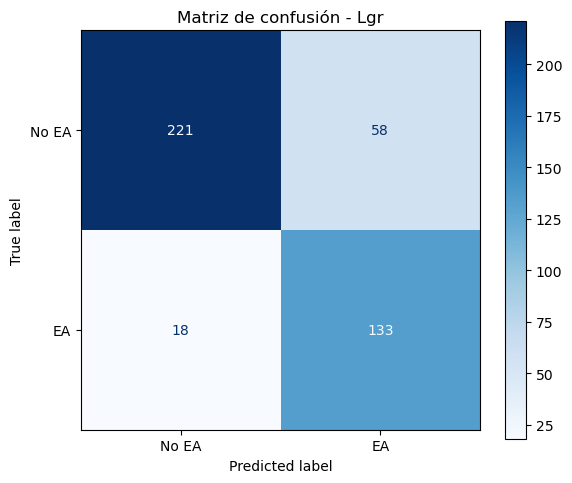

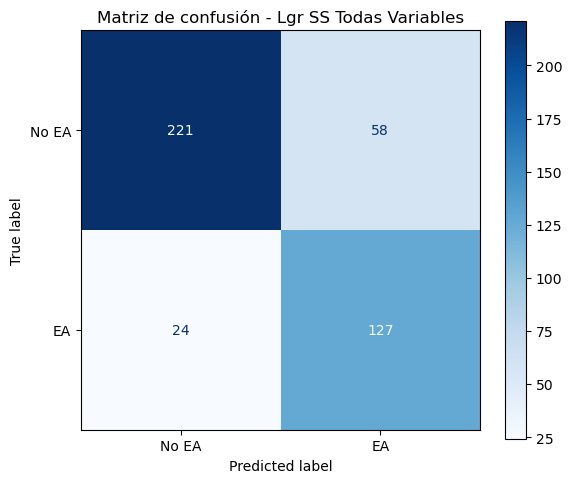

In [26]:
# Matrix Confusion
# Significant variables original values logistic regression
plot_confusion_matrix(y_test, y_pred_lgr, "Lgr", "cm_lgr.png")

# Full variables standard scaler logistic regression
plot_confusion_matrix(y_2_test, y_pred_lgr_ss_2, "Lgr SS Todas Variables", "cm_lgr_ss_full.png")

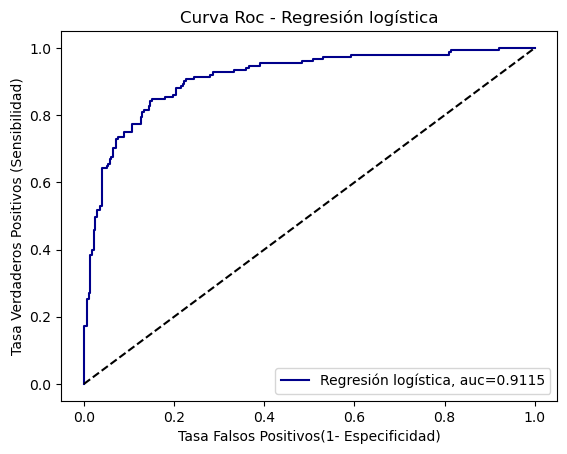

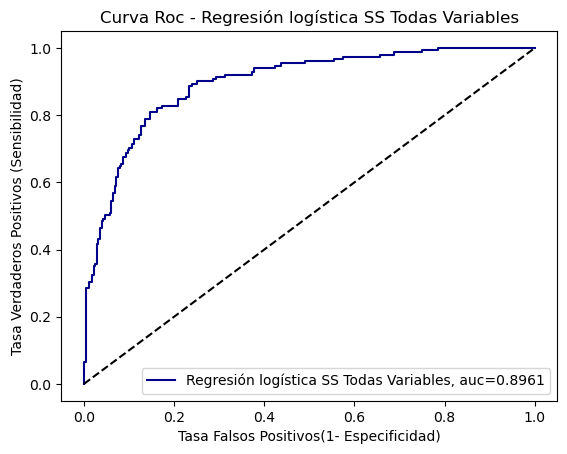

In [27]:
# ROC-AUC
# Significant variables original values logistic regression
y_prob_lr = logreg.predict_proba(X_test)[:,1]
plot_roc(y_test, y_prob_lr, "Regresión logística", "roc_lgr.jpg")

# Full variables StandardScaler logistic regression
y_prob_lr_ss_2 = logreg_ss_2.predict_proba(X_2_test_ss)[:,1]
plot_roc(y_2_test, y_prob_lr_ss_2, "Regresión logística SS Todas Variables", "roc_lgr_ss_full.jpg")

In [29]:
# GridSearch SVM
svm = SVC(random_state=myseed, probability=True)

param_grid_svm = [{"C": [0.01, 0.1, 1, 10, 50, 100, 200], "gamma": [0.001, 0.01, 0.1, 1, 10], "kernel" : ['rbf', 'sigmoid']},
             {"C": [0.01, 0.1, 1, 10, 50, 100, 200],  "kernel" : ['linear']}]

# Significant variables StandardScaler
grid_search_svm_ss = GridSearchCV(svm, param_grid=param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm_ss.fit(X_smote_ss, y_smote)

# Significant variables MinMax
grid_search_svm_mm = GridSearchCV(svm, param_grid=param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm_mm.fit(X_smote_mm, y_smote)

# Full variables StandardScaler
grid_search_svm_2_ss = GridSearchCV(svm, param_grid=param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm_2_ss.fit(X_2_smote_ss, y_2_smote)

# Full variables MinMax
grid_search_svm_2_mm = GridSearchCV(svm, param_grid=param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm_2_mm.fit(X_2_smote_mm, y_2_smote)

# Print resuults
print('Mejor GridSearchCV SVM StandardScaler variables signicativas: {:.2f}\n\n'.format(grid_search_svm_ss.best_score_))
print('Parametros mejor GridSearch SVM StandadardScaler variables significativas:','\n\n', (grid_search_svm_ss.best_params_))

print('Mejor GridSearchCV SVM MinMAX variables significativas: {:.2f}\n\n'.format(grid_search_svm_mm.best_score_))
print('Parametros mejor GridSearch SVM MinMax variables significativas:','\n\n', (grid_search_svm_mm.best_params_))


print('Mejor GridSearchCV SVM StandardScaler todas variables: {:.2f}\n\n'.format(grid_search_svm_2_ss.best_score_))
print('Parametros mejor GridSearch SVM StandadardScaler todas variables:','\n\n', (grid_search_svm_2_ss.best_params_))

print('Mejor GridSearchCV SVM MinMax todas variables: {:.2f}\n\n'.format(grid_search_svm_2_mm.best_score_))
print('Parametros mejor GridSearch SVM MinMax todas variables:','\n\n', (grid_search_svm_2_mm.best_params_))

# Build models
svm_ss = grid_search_svm_ss.best_estimator_
svm_mm = grid_search_svm_mm.best_estimator_
svm_2_ss = grid_search_svm_2_ss.best_estimator_
svm_2_mm = grid_search_svm_2_mm.best_estimator_

Mejor GridSearchCV SVM StandardScaler variables signicativas: 0.85


Parametros mejor GridSearch SVM StandadardScaler variables significativas: 

 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Mejor GridSearchCV SVM MinMAX variables significativas: 0.85


Parametros mejor GridSearch SVM MinMax variables significativas: 

 {'C': 50, 'gamma': 1, 'kernel': 'rbf'}
Mejor GridSearchCV SVM StandardScaler todas variables: 0.83


Parametros mejor GridSearch SVM StandadardScaler todas variables: 

 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor GridSearchCV SVM MinMax todas variables: 0.82


Parametros mejor GridSearch SVM MinMax todas variables: 

 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [30]:
# Accuracy train CV SVM
# Significant variables StandardScaler
cvscores_svm_ss = cross_val_score(svm_ss, X_smote_ss, y_smote, cv=5)

# Significant variables MinMax
cvscores_svm_mm = cross_val_score(svm_mm, X_smote_mm, y_smote, cv=5)

# Full variables StandardScaler
cvscores_svm_2_ss = cross_val_score(svm_2_ss, X_2_smote_ss, y_2_smote, cv=5)

# Full variables MinMax 
cvscores_svm_2_mm = cross_val_score(svm_2_mm, X_2_smote_mm, y_2_smote, cv=5)

# Print results
print("Precisión media obtenida variables significtivas StandardScaler SVM con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_svm_ss)*100, np.std(cvscores_svm_ss)*100))
print("Precisión media obtenida variables significtivas MinMax SVM con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_svm_mm)*100, np.std(cvscores_svm_mm)*100))
print("Precisión media obtenida todas significtivas StandardScaler SVM con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_svm_2_ss)*100, np.std(cvscores_svm_2_ss)*100))
print("Precisión media obtenida todas significtivas MinMax SVM con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_svm_2_mm)*100, np.std(cvscores_svm_2_mm)*100))

Precisión media obtenida variables significtivas StandardScaler SVM con  CV: 85.14 +- 2.40
Precisión media obtenida variables significtivas MinMax SVM con  CV: 84.91 +- 1.73
Precisión media obtenida todas significtivas StandardScaler SVM con  CV: 83.24 +- 4.92
Precisión media obtenida todas significtivas MinMax SVM con  CV: 82.30 +- 5.10


In [31]:
# SVM fit-Test Validate
# Significant variables Standard Scaler
svm_ss.fit(X_smote_ss, y_smote)
y_pred_svm_ss = svm_ss.predict(X_test_ss)

# Significant variables MinMax
svm_mm.fit(X_smote_mm, y_smote)
y_pred_svm_mm = svm_mm.predict(X_test_mm)

# Full variables Standard Scaler
svm_2_ss.fit(X_2_smote_ss, y_2_smote)
y_pred_svm_2_ss = svm_2_ss.predict(X_2_test_ss)

# Full variables MinMax
svm_2_mm.fit(X_2_smote_mm, y_2_smote)
y_pred_svm_2_mm = svm_2_mm.predict(X_2_test_mm)

# Test validate Significant variables StandardScaler
accuracy_svm_ss = accuracy_score(y_test, y_pred_svm_ss)
f1_svm_ss = f1_score(y_test, y_pred_svm_ss)

# Test validate Significant variables MinMax
accuracy_svm_mm = accuracy_score(y_test, y_pred_svm_mm)
f1_svm_mm = f1_score(y_test, y_pred_svm_mm)

# Test validate full variables StandardScaler
accuracy_svm_2_ss = accuracy_score(y_2_test, y_pred_svm_2_ss)
f1_svm_2_ss = f1_score(y_2_test, y_pred_svm_2_ss)

# Test validate full variables MinMax
accuracy_svm_2_mm = accuracy_score(y_2_test, y_pred_svm_2_mm)
f1_svm_2_mm = f1_score(y_2_test, y_pred_svm_2_mm)

# Print results
print("Accuracy Significant variables StandardScaler SVM: {:.2f}".format((accuracy_svm_ss)*100))
print("F1-score Significant variables StandardScaler SVM: {:.2f}".format((f1_svm_ss)*100))
print("Accuracy Significant variables MinMax SVM: {:.2f}".format((accuracy_svm_mm)*100))
print("F1-score Significant variables MinMax SVM: {:.2f}".format((f1_svm_mm)*100))
print("Accuracy Full variables StandardScaler SVM: {:.2f}".format((accuracy_svm_2_ss)*100))
print("F1-score Full variables StandardScaler SVM: {:.2f}".format((f1_svm_2_ss)*100))
print("Accuracy Full variables MinMax SVM: {:.2f}".format((accuracy_svm_2_mm)*100))
print("F1-score Full variables MinMax SVM: {:.2f}".format((f1_svm_2_mm)*100))

Accuracy Significant variables StandardScaler SVM: 90.23
F1-score Significant variables StandardScaler SVM: 86.27
Accuracy Significant variables MinMax SVM: 85.81
F1-score Significant variables MinMax SVM: 80.00
Accuracy Full variables StandardScaler SVM: 80.93
F1-score Full variables StandardScaler SVM: 73.38
Accuracy Full variables MinMax SVM: 81.16
F1-score Full variables MinMax SVM: 73.95


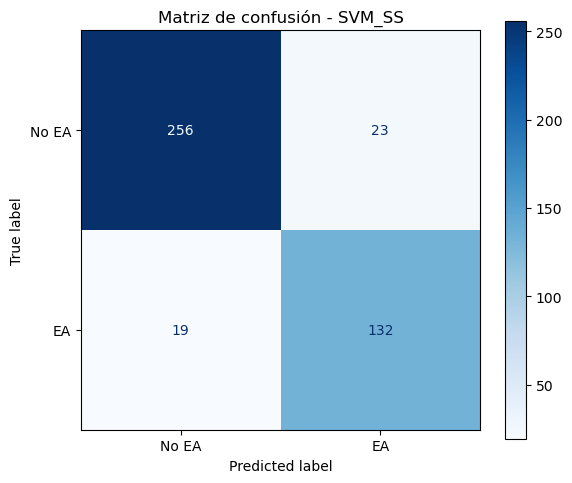

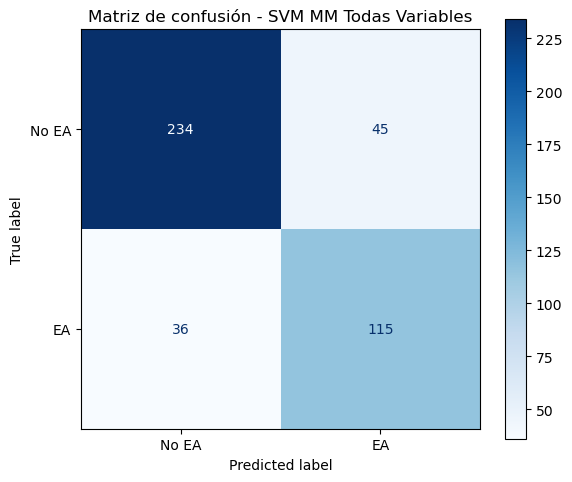

In [32]:
# Confusion Matrix SVM
# Significant varaibles StandardScaler
plot_confusion_matrix(y_test, y_pred_svm_ss, "SVM_SS", "cm_svm_ss.png")

# Full variables MinMax
plot_confusion_matrix(y_2_test, y_pred_svm_2_mm, "SVM MM Todas Variables", "cm_svm_ss_full.png")

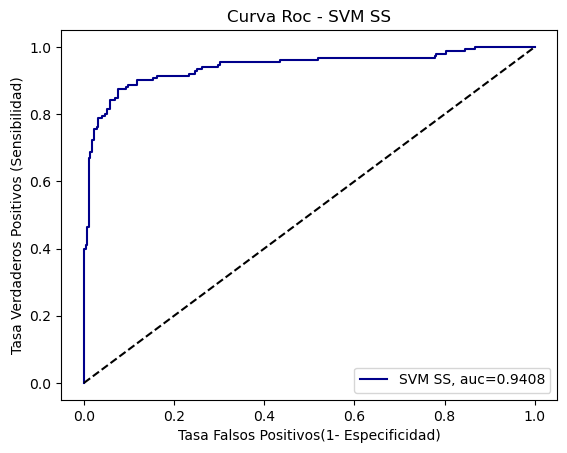

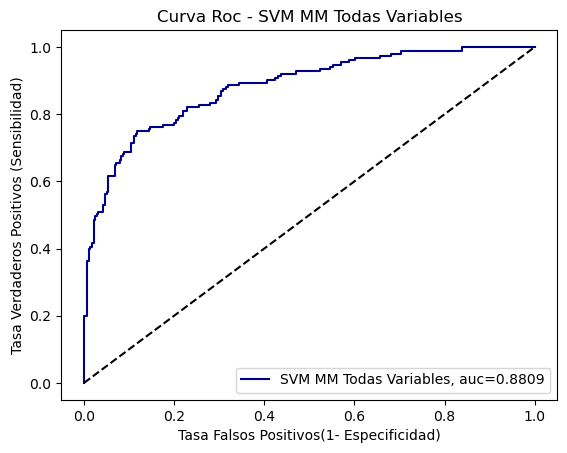

In [33]:
# ROC-AUC SVM
# Significant variables StandardScaler
y_prob_svm_ss = svm_ss.predict_proba(X_test_ss)[:,1]
plot_roc(y_test, y_prob_svm_ss, "SVM SS", "roc_svm_ss.jpg")

# Full variables MinMax
y_prob_svm_mm_2 = svm_2_mm.predict_proba(X_2_test_mm)[:,1]
plot_roc(y_2_test, y_prob_svm_mm_2, "SVM MM Todas Variables", "roc_svm_mm_full.jpg")

In [39]:
# GridSearch Decision Tree original values
dt = DecisionTreeClassifier(random_state=myseed)

param_grid = {"criterion": ['gini', 'entropy'], "max_depth": range(4, 15), 
              "min_samples_leaf": range(1, 20, 2), "min_samples_split": [2, 10, 20, 50, 100],
             "max_leaf_nodes": range(2, 26, 2)}
param_grid_2 = {"criterion": ['gini', 'entropy'], "max_depth": range(4, 15), 
              "min_samples_leaf": range(1, 10), "min_samples_split": [2, 5, 10, 20, 50],
             "max_leaf_nodes": range(10, 50, 10)}

# Significant variables
grid_search_dt = GridSearchCV(dt, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_dt.fit(X_smote, y_smote)

# Full variables
grid_search_dt_2 = GridSearchCV(dt, param_grid=param_grid_2, cv=5, n_jobs=-1)
grid_search_dt_2.fit(X_2_smote, y_2_smote)

# Print results
print('Mejor GridSearch DT CV variables significativas: {:.2f}\n\n'.format(grid_search_dt.best_score_))

print('Parametros mejor GridSearch DT variables signiticativas:','\n\n', (grid_search_dt.best_params_))

print('Mejor GridSearch DT CV todas variables: {:.2f}\n\n'.format(grid_search_dt_2.best_score_))

print('Parametros mejor GridSearch DT todas variables:','\n\n', (grid_search_dt_2.best_params_))

# Build model
dt = grid_search_dt.best_estimator_
dt_2 = grid_search_dt_2.best_estimator_

Mejor GridSearch DT CV variables significativas: 0.89


Parametros mejor GridSearch DT variables signiticativas: 

 {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor GridSearch DT CV todas variables: 0.90


Parametros mejor GridSearch DT todas variables: 

 {'criterion': 'entropy', 'max_depth': 12, 'max_leaf_nodes': 40, 'min_samples_leaf': 9, 'min_samples_split': 2}


In [40]:
# Accuracy train CV DT
# Significant variables
cvscores_dt = cross_val_score(dt, X_smote, y_smote, cv=5)

# Full variables
cvscores_dt_2 = cross_val_score(dt_2, X_2_smote, y_2_smote, cv=5)

# Print results
print("Precisión media obtenida variables significativas DT con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_dt)*100, np.std(cvscores_dt)*100))
print("Precisión media obtenida todas variables DT con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_dt_2)*100, np.std(cvscores_dt_2)*100))

Precisión media obtenida variables significativas DT con  CV: 88.69 +- 5.54
Precisión media obtenida todas variables DT con  CV: 89.50 +- 2.84


In [41]:
# DT fit
# Significant variables
dt.fit(X_smote, y_smote)
y_pred_dt = dt.predict(X_test)

# Full variables
dt_2.fit(X_2_smote, y_2_smote)
y_pred_dt_2 = dt_2.predict(X_2_test)

# test validate significant variables
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# test validate full variables
accuracy_dt_2 = accuracy_score(y_2_test, y_pred_dt_2)
f1_dt_2 = f1_score(y_2_test, y_pred_dt_2)

# Print results
print("Accuracy Variables significativas DT: {:.2f}".format((accuracy_dt)*100))
print("F1-score variables significativas DT: {:.2f}".format((f1_dt)*100))
print("Accuracy todas significativas DT: {:.2f}".format((accuracy_dt_2)*100))
print("F1-score todas significativas DT: {:.2f}".format((f1_dt_2)*100))

Accuracy Variables significativas DT: 95.58
F1-score variables significativas DT: 93.56
Accuracy todas significativas DT: 94.42
F1-score todas significativas DT: 92.05


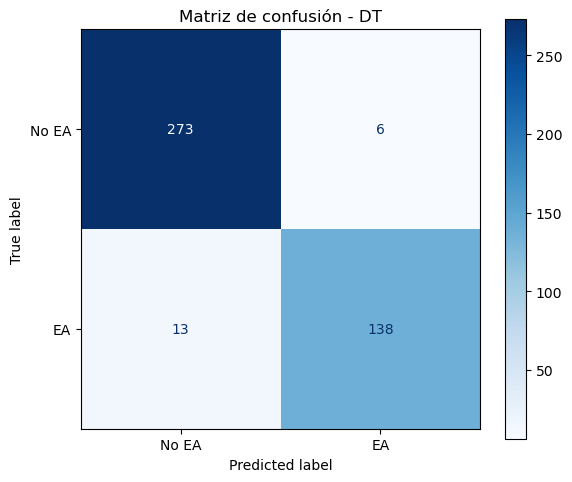

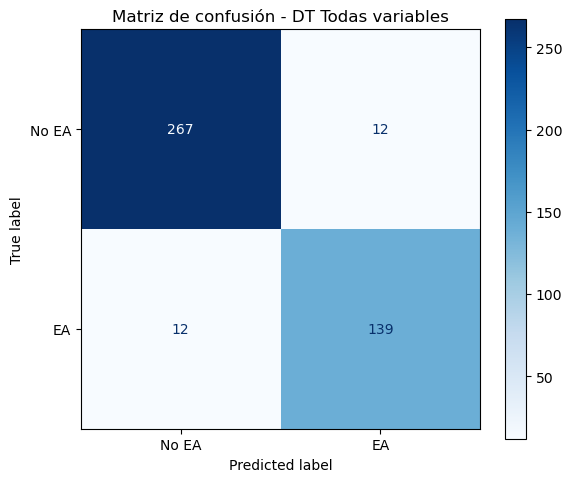

In [42]:
# DT Matrix confusion
# Significant variables
plot_confusion_matrix(y_test, y_pred_dt, "DT", "DT.png")

# Full variables
plot_confusion_matrix(y_2_test, y_pred_dt_2, "DT Todas variables", "DT_full.png")

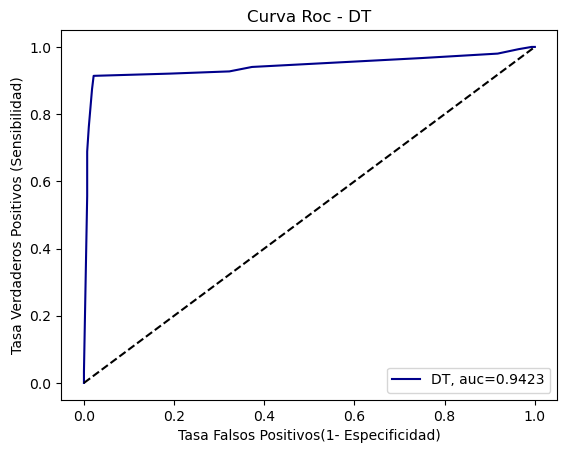

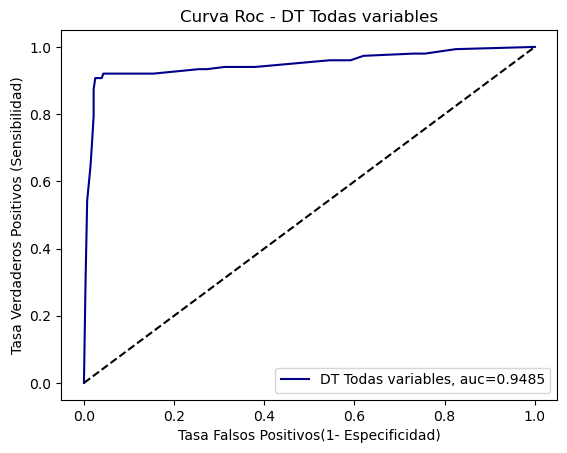

In [43]:
# DT ROC-AUC
# Significant variables
y_prob_dt = dt.predict_proba(X_test)[:,1]
plot_roc(y_test, y_prob_dt, "DT", "roc_dt.jpg")

# Full variables
y_prob_dt_2 = dt_2.predict_proba(X_2_test)[:,1]
plot_roc(y_2_test, y_prob_dt_2, "DT Todas variables", "roc_dt_full.jpg")

In [44]:
# Random Forest RandomizeSearch
rf = RandomForestClassifier(random_state=myseed)

param_dist = {"max_depth": range(2, 5), 
              "min_samples_leaf": range(1, 20, 2), "min_samples_split": [2, 10, 20, 50, 100],
             "max_features": ["sqrt", "log2", None], "n_estimators": [10, 50, 100, 200, 300, 400, 500]}
param_dist_2 = {"max_depth": range(5, 20), 
              "min_samples_leaf": range(1, 10, 1), "min_samples_split": [2, 5, 10, 20, 50],
             "max_features": ["sqrt", "log2", None], "n_estimators": [50, 100, 200, 300, 400, 500]}

# Significant variables
random_rf = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter= 100, cv=5, n_jobs=-1)
random_rf.fit(X_smote, y_smote)

# Full variables
random_rf_2 = RandomizedSearchCV(rf, param_distributions=param_dist_2, n_iter= 100, cv=5, n_jobs=-1)
random_rf_2.fit(X_2_smote, y_2_smote)

# Print results
print('Mejor GridSearch RF CV variables significativas: {:.2f}\n\n'.format(random_rf.best_score_))

print('Parametros mejor GridSearch RF variables significativas:','\n\n', (random_rf.best_params_))

print('Mejor GridSearch RF CV todas variables: {:.2f}\n\n'.format(random_rf_2.best_score_))

print('Parametros mejor GridSearch RF todas variables:','\n\n', (random_rf_2.best_params_))

# Build model
rf = random_rf.best_estimator_
rf_2 = random_rf_2.best_estimator_

Mejor GridSearch RF CV variables significativas: 0.88


Parametros mejor GridSearch RF variables significativas: 

 {'n_estimators': 300, 'min_samples_split': 50, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'max_depth': 4}
Mejor GridSearch RF CV todas variables: 0.90


Parametros mejor GridSearch RF todas variables: 

 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14}


In [45]:
# RF train accuracy
# Significant variables
cvscores_rf = cross_val_score(rf, X_smote, y_smote, cv=5)

# Full variables
cvscores_rf_2 = cross_val_score(rf_2, X_2_smote, y_2_smote, cv=5)

# Print results
print("Precisión media obtenida variables significativas RF con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_rf)*100, np.std(cvscores_rf)*100))
print("Precisión media obtenida todas variables RF con  CV: {:.2f} +- {:.2f}".format(
    np.mean(cvscores_rf_2)*100, np.std(cvscores_rf_2)*100))

Precisión media obtenida variables significativas RF con  CV: 87.97 +- 4.47
Precisión media obtenida todas variables RF con  CV: 90.14 +- 2.48


In [46]:
# RF fit
# Significant variables
rf.fit(X_smote, y_smote)
y_pred_rf =rf.predict(X_test)

# Full variables
rf_2.fit(X_2_smote, y_2_smote)
y_pred_rf_2 =rf_2.predict(X_2_test)

# test validate Significant variables
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# test validate full variables
accuracy_rf_2 = accuracy_score(y_2_test, y_pred_rf_2)
f1_rf_2 = f1_score(y_2_test, y_pred_rf_2)

# Print results
print("Accuracy variables significativas RF: {:.2f}".format((accuracy_rf)*100))
print("F1-score variables significativas RF: {:.2f}".format((f1_rf)*100))
print("Accuracy todas variables RF: {:.2f}".format((accuracy_rf_2)*100))
print("F1-score todas variables RF: {:.2f}".format((f1_rf_2)*100))

Accuracy variables significativas RF: 94.65
F1-score variables significativas RF: 92.10
Accuracy todas variables RF: 92.33
F1-score todas variables RF: 88.50


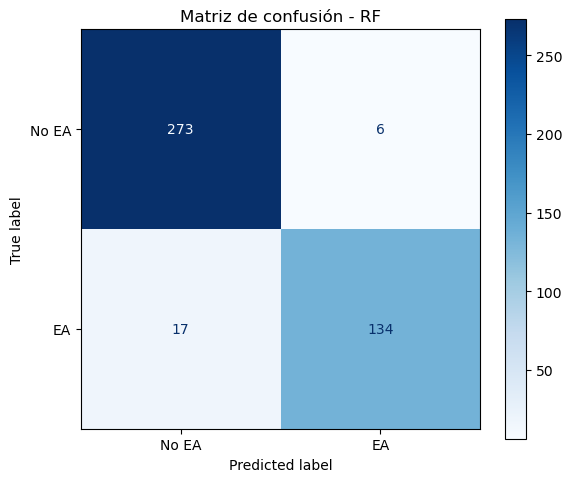

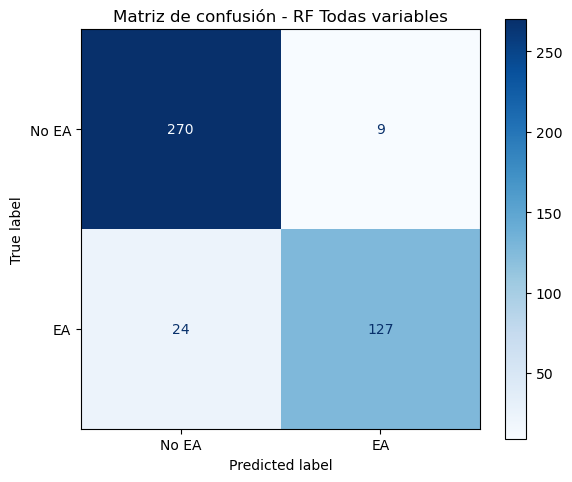

In [47]:
# RF matrix confusion
# Significant variables
plot_confusion_matrix(y_test, y_pred_rf, "RF", "mc RF.png")

# Full variables
plot_confusion_matrix(y_2_test, y_pred_rf_2, "RF Todas variables", "mc_RF_full.png")

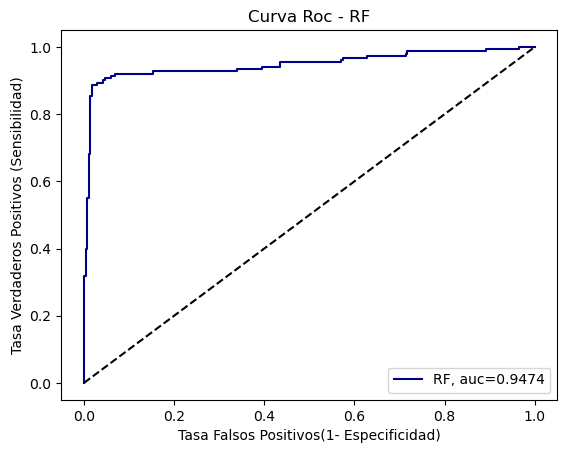

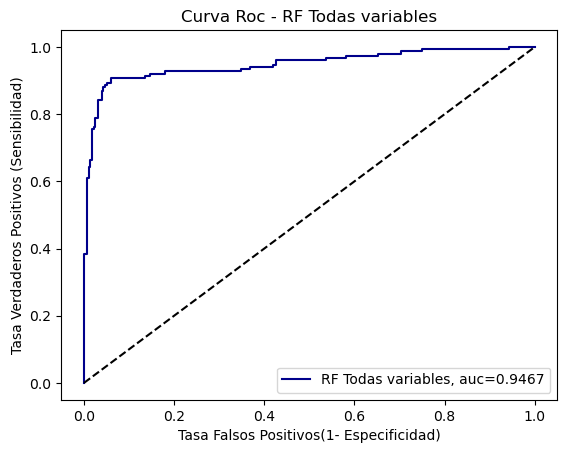

In [48]:
# RF ROC-AUC
# Significant variables
y_prob_rf = rf.predict_proba(X_test)[:,1]
plot_roc(y_test, y_prob_rf, "RF", "roc_rf.png")

# Full variables
y_prob_rf_2 = rf_2.predict_proba(X_2_test)[:,1]
plot_roc(y_2_test, y_prob_rf_2, "RF Todas variables", "roc_rf_full.png")

In [30]:
# Model ANN

# Input shapes
input_shape = X_smote_mm.shape[1]
input_shape_2 = X_2_smote_mm.shape[1]

# Fixed seed
keras.utils.set_random_seed(myseed)

# Model Significant variables
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(input_shape, )))

    layers = hp.Int('layers', 1, 3)
    units_0 = hp.Int('units_0', min_value=16, max_value=64, step=16)

    model.add(Dense(units = units_0, activation='relu'))
    
    for i in range(1, layers):
        units = hp.Int(f'units_{i}', min_value=16, max_value=units_0, step=16)
        model.add(Dense(units=units, activation='relu'))
        units_0 = units

    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    l_r = hp.Float('learning_rate', 1e-5, 1e-2, sampling = 'log')

    opt = tf.keras.optimizers.Adam(learning_rate= l_r)

    model.compile(
        optimizer = opt,
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    return model

# Model full variables
def build_model_2(hp):
    model = Sequential()
    model.add(Input(shape=(input_shape_2, )))

    layers = hp.Int('layers', 1, 4)
    units_0 = hp.Int('units_0', min_value=64, max_value=256, step=32)

    model.add(Dense(units = units_0, activation='relu'))
    
    for i in range(1, layers):
        units = hp.Int(f'units_{i}', min_value=16, max_value=units_0, step=16)
        model.add(Dense(units=units, activation='relu'))
        units_0 = units

    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    l_r = hp.Float('learning_rate', 1e-5, 1e-2, sampling = 'log')

    opt = tf.keras.optimizers.Adam(learning_rate= l_r)

    model.compile(
        optimizer = opt,
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    return model

# Callbacks
e_s = EarlyStopping(monitor = 'val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, 
                                                 patience=3, min_lr=1e-6)

In [44]:
# Tunning Significant variables MinMax
tuner = kt.RandomSearch(
    build_model,
    objective = kt.Objective('val_loss', direction='min'),
    max_trials = 30,
    executions_per_trial = 3,
    directory = 'hyperparameter_tuning',
    project_name = 'mlp_tuning_33'
)
tuner.search(X_smote_mm, y_smote, epochs = 100, 
            batch_size = 32, validation_split= 0.2, callbacks=[e_s, reduce_lr])

Reloading Tuner from hyperparameter_tuning\mlp_tuning_33\tuner0.json


In [45]:
# Hyperparameters significant variables MinMax
tuner.results_summary(1)

Results summary
Results in hyperparameter_tuning\mlp_tuning_33
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 24 summary
Hyperparameters:
layers: 3
units_0: 64
dropout: 0.30000000000000004
learning_rate: 0.0034042943664654214
units_1: 48
units_2: 16
Score: 0.566542903582255


In [46]:
# Fit model significant variables MinMax
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(5)

history = best_model.fit(X_smote_mm, y_smote, epochs=100, batch_size=32, validation_split=0.2, callbacks=[e_s, reduce_lr], verbose=1)

Epoch 1/100
56/56 [==============================] - 1s 4ms/step - loss: 0.3412 - accuracy: 0.8722 - val_loss: 0.6605 - val_accuracy: 0.7252 - lr: 0.0034
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.8874 - val_loss: 0.7042 - val_accuracy: 0.7005 - lr: 0.0034
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3259 - accuracy: 0.8818 - val_loss: 0.8560 - val_accuracy: 0.6284 - lr: 0.0034
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3137 - accuracy: 0.8913 - val_loss: 0.8682 - val_accuracy: 0.6351 - lr: 0.0034
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 0.2759 - accuracy: 0.9065 - val_loss: 0.8099 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 0.2767 - accuracy: 0.9105 - val_loss: 0.8354 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 7/100
56/56 [==============================] - 0s 2ms/step - loss: 0.2

In [39]:
# Tunning Significant variables StandardScaler
tuner_ss = kt.RandomSearch(
    build_model,
    objective = kt.Objective('val_loss', direction='min'),
    max_trials = 30,
    executions_per_trial = 3,
    directory = 'hyperparameter_tuning',
    project_name = 'mlp_tuning_60'
)
tuner_ss.search(X_smote_ss, y_smote, epochs = 100, 
            batch_size = 32, validation_split= 0.2, callbacks=[e_s, reduce_lr])

Reloading Tuner from hyperparameter_tuning\mlp_tuning_60\tuner0.json


In [40]:
# Hyperparameters significant variables StandardScaler
tuner_ss.results_summary(1)

Results summary
Results in hyperparameter_tuning\mlp_tuning_60
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
layers: 2
units_0: 48
dropout: 0.4
learning_rate: 1.225389009438056e-05
units_1: 16
units_2: 16
Score: 0.565456340710322


In [41]:
# Fit model significant variables StandardScaler
best_model_ss = tuner_ss.get_best_models(num_models=1)[0]
best_hps_ss = tuner_ss.get_best_hyperparameters(5)

history_ss = best_model_ss.fit(X_smote_ss, y_smote, epochs=100, batch_size=32, validation_split=0.2, callbacks=[e_s, reduce_lr], verbose=1)

Epoch 1/100
56/56 [==============================] - 1s 3ms/step - loss: 0.8047 - accuracy: 0.4330 - val_loss: 0.5038 - val_accuracy: 0.9842 - lr: 1.2254e-05
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7999 - accuracy: 0.4291 - val_loss: 0.5093 - val_accuracy: 0.9797 - lr: 1.2254e-05
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7734 - accuracy: 0.4459 - val_loss: 0.5145 - val_accuracy: 0.9775 - lr: 1.2254e-05
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7752 - accuracy: 0.4555 - val_loss: 0.5198 - val_accuracy: 0.9707 - lr: 1.2254e-05
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7682 - accuracy: 0.4668 - val_loss: 0.5214 - val_accuracy: 0.9707 - lr: 3.6762e-06
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7615 - accuracy: 0.4685 - val_loss: 0.5229 - val_accuracy: 0.9685 - lr: 3.6762e-06
Epoch 7/100
56/56 [==============================] -

In [31]:
# Tunning full variables StandardScaler
tuner_ss_2 = kt.RandomSearch(
    build_model_2,
    objective = kt.Objective('val_loss', direction='min'),
    max_trials = 30,
    executions_per_trial = 3,
    directory = 'hyperparameter_tuning',
    project_name = 'mlp_tuning_51'
)

tuner_ss_2.search(X_2_smote_ss, y_2_smote, epochs = 100, 
            batch_size = 32, validation_split= 0.2, callbacks=[e_s, reduce_lr])

Trial 30 Complete [00h 00m 15s]
val_loss: 0.7906878391901652

Best val_loss So Far: 0.4748506347338359
Total elapsed time: 00h 05m 44s


In [32]:
# Hyperparameters full variables StandardScaler
tuner_ss_2.results_summary(1)

Results summary
Results in hyperparameter_tuning\mlp_tuning_51
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 19 summary
Hyperparameters:
layers: 2
units_0: 160
dropout: 0.1
learning_rate: 0.0015662035879940982
units_1: 112
units_2: 16
units_3: 16
Score: 0.4748506347338359


In [48]:
# Fit model full variables StandardScaler
best_model_ss_2 = tuner_ss_2.get_best_models(num_models=1)[0]
best_hps_ss_2 = tuner_ss_2.get_best_hyperparameters(5)

history_ss_2 = best_model_ss_2.fit(X_2_smote_ss, y_2_smote, epochs=100, batch_size=32, validation_split=0.2, callbacks=[e_s, reduce_lr], verbose=1)

Epoch 1/100
56/56 [==============================] - 1s 4ms/step - loss: 0.1197 - accuracy: 0.9640 - val_loss: 0.5860 - val_accuracy: 0.7500 - lr: 0.0016
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.9758 - val_loss: 0.5982 - val_accuracy: 0.7477 - lr: 0.0016
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.0748 - accuracy: 0.9820 - val_loss: 0.6624 - val_accuracy: 0.7387 - lr: 0.0016
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 0.0657 - accuracy: 0.9831 - val_loss: 0.6248 - val_accuracy: 0.7455 - lr: 0.0016
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9961 - val_loss: 0.5826 - val_accuracy: 0.7590 - lr: 4.6986e-04
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9961 - val_loss: 0.6239 - val_accuracy: 0.7568 - lr: 4.6986e-04
Epoch 7/100
56/56 [==============================] - 0s 2ms/step - l

In [35]:
# Tunning full variables MinMax
tuner_mm_2 = kt.RandomSearch(
    build_model_2,
    objective = kt.Objective('val_loss', direction='min'),
    max_trials = 30,
    executions_per_trial = 3,
    directory = 'hyperparameter_tuning',
    project_name = 'mlp_tuning_36'
)

tuner_mm_2.search(X_2_smote_mm, y_2_smote, epochs = 100, 
            batch_size = 32, validation_split= 0.2, callbacks=[e_s, reduce_lr])

Reloading Tuner from hyperparameter_tuning\mlp_tuning_36\tuner0.json


In [50]:
# Hyperparameters full variables MinMax
tuner_mm_2.results_summary(1)

Results summary
Results in hyperparameter_tuning\mlp_tuning_36
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
layers: 3
units_0: 96
dropout: 0.2
learning_rate: 0.009837687450413713
units_1: 64
units_2: 16
units_3: 16
Score: 0.4713493188222249


In [36]:
# Fit model full variables MinMax
best_model_mm_2 = tuner_mm_2.get_best_models(num_models=1)[0]
best_hps_mm_2 = tuner_mm_2.get_best_hyperparameters(5)

history_mm_2 = best_model_mm_2.fit(X_2_smote_ss, y_2_smote, epochs=100, batch_size=32, validation_split=0.2, callbacks=[e_s, reduce_lr], verbose=1)

Epoch 1/100
56/56 [==============================] - 1s 4ms/step - loss: 0.4783 - accuracy: 0.8626 - val_loss: 0.6813 - val_accuracy: 0.6757 - lr: 0.0030
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.2662 - accuracy: 0.9009 - val_loss: 0.5437 - val_accuracy: 0.7297 - lr: 0.0030
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.2296 - accuracy: 0.9155 - val_loss: 0.6850 - val_accuracy: 0.7005 - lr: 0.0030
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 0.2066 - accuracy: 0.9341 - val_loss: 0.6459 - val_accuracy: 0.7027 - lr: 0.0030
Epoch 5/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1724 - accuracy: 0.9414 - val_loss: 0.6987 - val_accuracy: 0.7005 - lr: 0.0030
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.9505 - val_loss: 0.6775 - val_accuracy: 0.7500 - lr: 8.8539e-04
Epoch 7/100
56/56 [==============================] - 0s 2ms/step - loss:

In [51]:
# Evaluate model on test
results_mm = best_model.evaluate(X_test, y_test)
results_ss = best_model_ss.evaluate(X_test, y_test)
results_mm_2 = best_model_mm_2.evaluate(X_2_test, y_2_test)
results_ss_2 = best_model_ss_2.evaluate(X_2_test, y_2_test)

# Print results
print("Resultado en el conjunto de test variables significtivas SS (loss, acc):{}".format(results_ss))
print("Resultado en el conjunto de test variables significtivas MM (loss, acc):{}".format(results_mm))
print("Resultado en el conjunto de test todas variables SS (loss, acc):{}".format(results_ss_2))
print("Resultado en el conjunto de test todas variables MM (loss, acc):{}".format(results_mm_2))

14/14 [==============================] - 0s 2ms/step - loss: 40.9882 - accuracy: 0.5674
Resultado en el conjunto de test variables significtivas SS (loss, acc):[26.49923324584961, 0.35116279125213623]
Resultado en el conjunto de test variables significtivas MM (loss, acc):[32.537506103515625, 0.6534883975982666]
Resultado en el conjunto de test todas variables SS (loss, acc):[40.988155364990234, 0.5674418807029724]
Resultado en el conjunto de test todas variables MM (loss, acc):[35.092491149902344, 0.6488372087478638]


In [49]:
# Test evaluate ANN
# Significant variables StandadScaler
y_pred_ann_ss = best_model_ss.predict(X_test_ss, verbose=0)
y_pred_labels_ss = (y_pred_ann_ss > 0.5).astype(int)

accuracy_ann_ss = accuracy_score(y_test, y_pred_labels_ss)
f1_ann_ss = f1_score(y_test, y_pred_labels_ss)

# Significant variables MinMax
y_pred_ann_mm = best_model.predict(X_test_mm, verbose=0)
y_pred_labels_mm = (y_pred_ann_mm > 0.5).astype(int)

accuracy_ann_mm = accuracy_score(y_test, y_pred_labels_mm)
f1_ann_mm = f1_score(y_test, y_pred_labels_mm)

# Full variables StandadScaler
y_pred_ann_ss_2 = best_model_ss_2.predict(X_2_test_ss, verbose=0)
y_pred_labels_ss_2 = (y_pred_ann_ss_2 > 0.5).astype(int)

accuracy_ann_ss_2 = accuracy_score(y_2_test, y_pred_labels_ss_2)
f1_ann_ss_2 = f1_score(y_2_test, y_pred_labels_ss_2)

# Full variables MinMax
y_pred_ann_mm_2 = best_model_mm_2.predict(X_2_test_mm, verbose=0)
y_pred_labels_mm_2 = (y_pred_ann_mm_2 > 0.5).astype(int)

accuracy_ann_mm_2 = accuracy_score(y_2_test, y_pred_labels_mm_2)
f1_ann_mm_2 = f1_score(y_2_test, y_pred_labels_mm_2)

# Print results
print("Accuracy variables significantes StandardScaler ANN: {:.2f}".format((accuracy_ann_ss)*100))
print("F1-score variables significantes StandardScaler ANN: {:.2f}".format((f1_ann_ss)*100))
print("Accuracy variables significantes MinMax ANN: {:.2f}".format((accuracy_ann_mm)*100))
print("F1-score variables significantes MinMax ANN: {:.2f}".format((f1_ann_mm)*100))
print("Accuracy todas variables StandardScaler ANN: {:.2f}".format((accuracy_ann_ss_2)*100))
print("F1-score todas variables StandardScaler ANN: {:.2f}".format((f1_ann_ss_2)*100))
print("Accuracy todas variables MinMax ANN: {:.2f}".format((accuracy_ann_mm_2)*100))
print("F1-score todas variables MinMax ANN: {:.2f}".format((f1_ann_mm_2)*100))

Accuracy variables significantes StandardScaler ANN: 38.37
F1-score variables significantes StandardScaler ANN: 52.59
Accuracy variables significantes MinMax ANN: 90.23
F1-score variables significantes MinMax ANN: 86.54
Accuracy todas variables StandardScaler ANN: 82.09
F1-score todas variables StandardScaler ANN: 73.54
Accuracy todas variables MinMax ANN: 83.72
F1-score todas variables MinMax ANN: 74.26


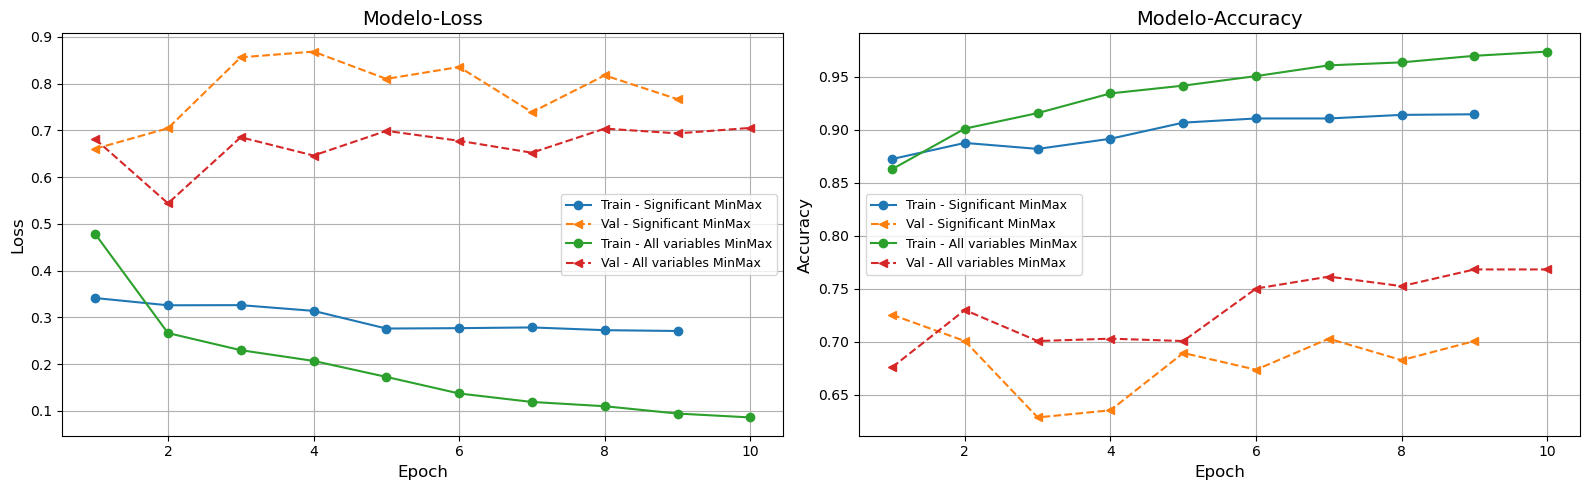

In [54]:
hist_mm = history.history
hist_ss = history_ss.history
hist_mm_2 = history_mm_2.history
hist_ss_2 = history_ss_2.history

histories = {
    "Significant MinMax": hist_mm,
    "All variables MinMax": hist_mm_2,
}


fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gràfica de pèrdua (loss)
for label, hist in histories.items():
    x_arr = np.arange(len(hist['loss'])) + 1
    axes[0].plot(x_arr, hist['loss'], '-o', label=f'Train - {label}')
    axes[0].plot(x_arr, hist['val_loss'], '--<', label=f'Val - {label}')
axes[0].set_title("Modelo-Loss", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].legend(fontsize=9)
axes[0].grid(True)

# Gràfica d’accuracy
for label, hist in histories.items():
    x_arr = np.arange(len(hist['accuracy'])) + 1
    axes[1].plot(x_arr, hist['accuracy'], '-o', label=f'Train - {label}')
    axes[1].plot(x_arr, hist['val_accuracy'], '--<', label=f'Val - {label}')
axes[1].set_title("Modelo-Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].legend(fontsize=9)
axes[1].grid(True)

plt.tight_layout()
plt.savefig("performance_plot.png", dpi=300)
plt.show()

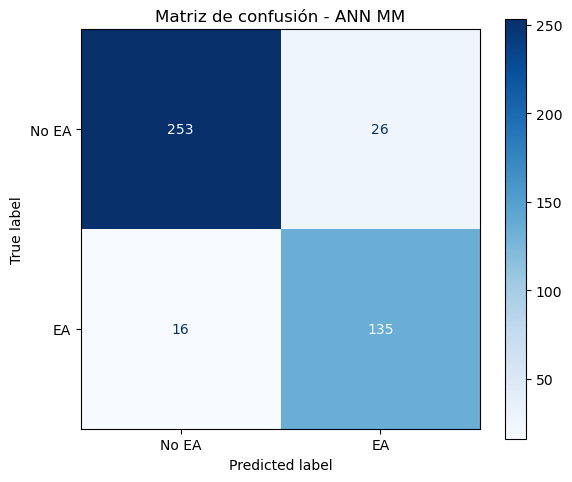

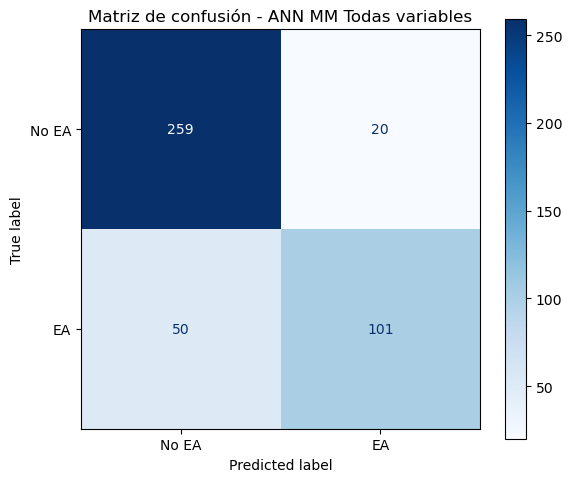

In [55]:
# ANN matrix confusion
# Significant Variables MinMax
plot_confusion_matrix(y_test, y_pred_labels_mm, "ANN MM", "mc_ann.png")
# All variables MinMax
plot_confusion_matrix(y_2_test, y_pred_labels_mm_2, "ANN MM Todas variables", "mc_ann_full.png")

14/14 [==============================] - 0s 757us/step


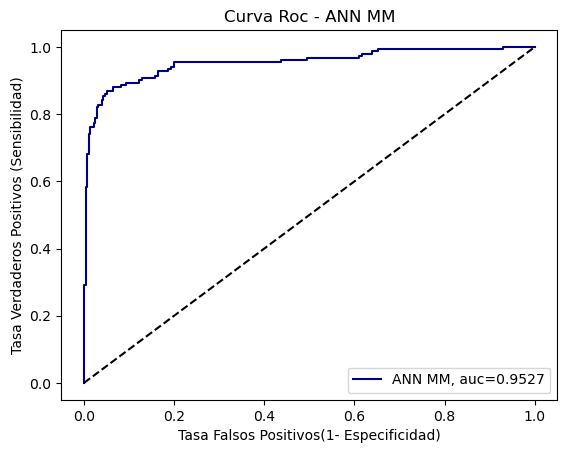

14/14 [==============================] - 0s 2ms/step


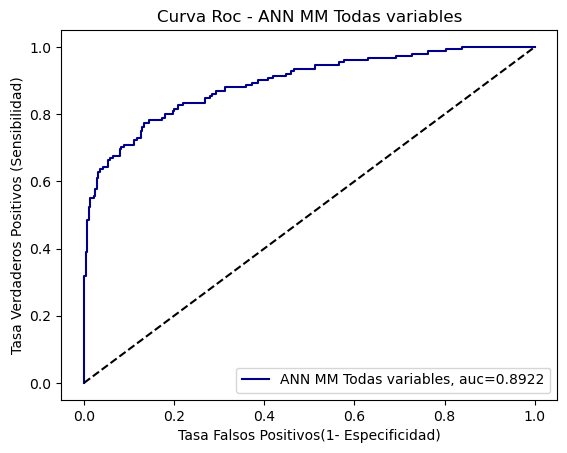

In [57]:
# ANN ROC-AUC
# Significant Variables MinMax
y_prob_ann_mm = best_model.predict(X_test_mm)
plot_roc(y_test, y_prob_ann_mm, "ANN MM", "roc_ann_mm.png")

# All variables MinMax
y_prob_ann_mm_2 = best_model_mm_2.predict(X_2_test_ss)
plot_roc(y_2_test, y_prob_ann_mm_2, "ANN MM Todas variables", "roc_ann_mm_full.png")